In [74]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [75]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

In [109]:
hyd_coords_wgs84 = (78.175278,17.192619,78.715668,17.643368)
resolution=(5500, 3500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (5500, 3500) m resolution: (11, 14) pixels


In [143]:
evalscript_1 = """
//VERSION=3
function setup() {
  return {
    input: ["NO2", "dataMask"],
    output: { bands: 4 },
  }
}

const minVal = 0.0
const maxVal = 0.000075
const diff = maxVal - minVal

const rainbowColors = [
  [minVal, [0, 0, 0.5]],
  [minVal + 0.125 * diff, [0, 0, 1]],
  [minVal + 0.375 * diff, [0, 1, 1]],
  [minVal + 0.625 * diff, [1, 1, 0]],
  [minVal + 0.875 * diff, [1, 0, 0]],
  [maxVal, [0.5, 0, 0]],
]

const viz = new ColorRampVisualizer(rainbowColors)

function evaluatePixel(sample) {
  var rgba = viz.process(sample.NO2)
  rgba.push(sample.dataMask)
  var maskValue = sample.dataMask; 
  return rgba
}
"""



request_true_color = SentinelHubRequest(
    evalscript=evalscript_1,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL5P.define_from(
                "s5pl2", service_url=config.sh_base_url
            ),
            time_interval=("2021-07-16", "2021-07-17"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=hyd_bbox,
    size=hyd_size,
    config=config,
)

In [144]:
image = request_true_color.get_data()[0]

In [145]:
print(np.shape(image))

(14, 11, 4)


In [146]:
print(image)

[[[  0 185 255 255]
  [  0 151 255 255]
  [  0 151 255 255]
  [  0  99 255 255]
  [  0 189 255 255]
  [  0  56 255 255]
  [  0 111 255 255]
  [  0  39 255 255]
  [128   0   0   0]
  [128   0   0   0]
  [128   0   0   0]]

 [[  0   0 249 255]
  [  0   0 249 255]
  [  0 194 255 255]
  [  0 140 255 255]
  [  0 189 255 255]
  [  0 180 255 255]
  [  0 252 255 255]
  [  0  39 255 255]
  [  0 172 255 255]
  [  0 240 255 255]
  [128   0   0   0]]

 [[  0 121 255 255]
  [  0  41 255 255]
  [  0 194 255 255]
  [ 71 255 184 255]
  [ 52 255 203 255]
  [  0 180 255 255]
  [ 65 255 190 255]
  [ 65 255 190 255]
  [  0 172 255 255]
  [  0 233 255 255]
  [  0 163 255 255]]

 [[  0 121 255 255]
  [  0 139 255 255]
  [  0  84 255 255]
  [ 71 255 184 255]
  [ 71 255 184 255]
  [115 255 140 255]
  [115 255 140 255]
  [228 255  27 255]
  [  0 197 255 255]
  [  0 233 255 255]
  [  0 163 255 255]]

 [[ 66 255 189 255]
  [  0 139 255 255]
  [  0  84 255 255]
  [111 255 144 255]
  [ 71 255 184 255]
  [ 71 255 1

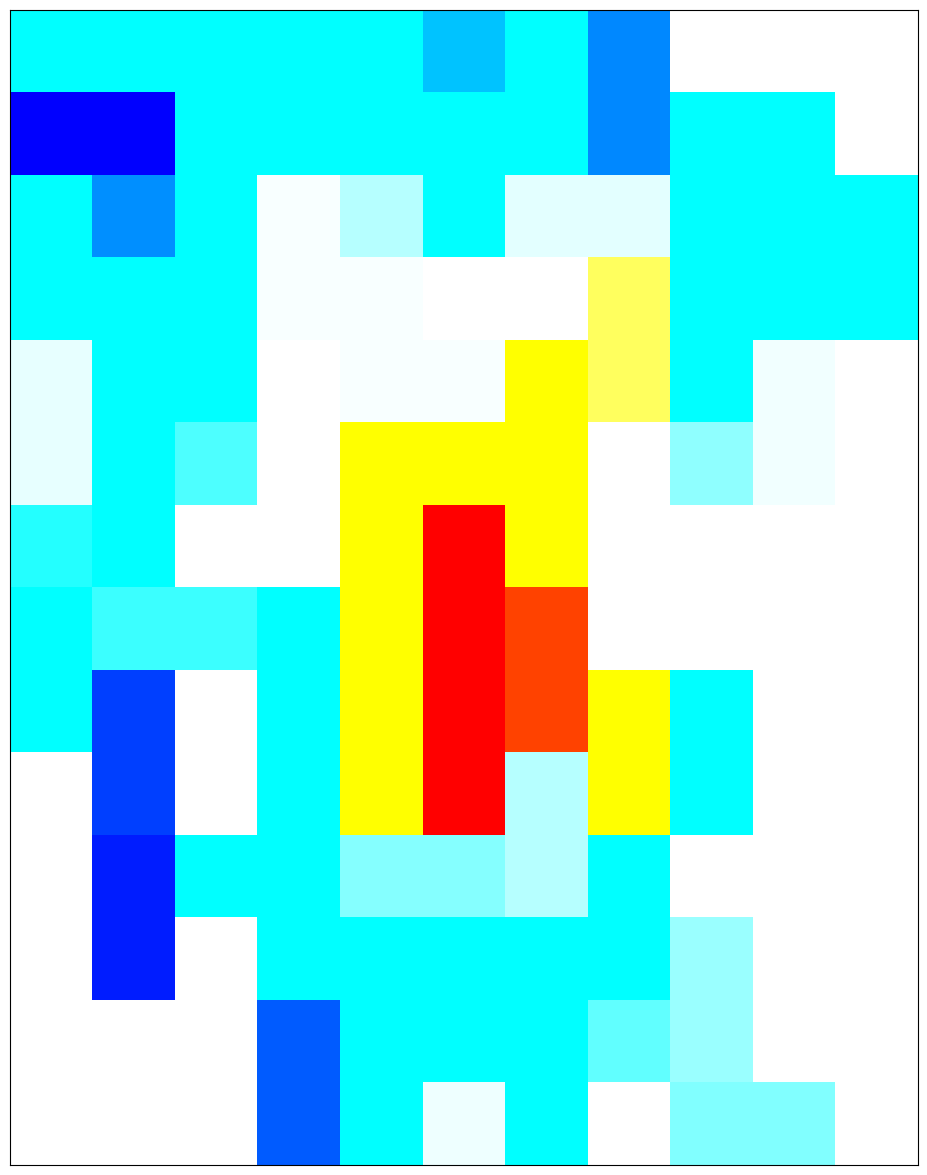

In [147]:
%matplotlib inline

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [148]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: { 
            bands: 4 
        },
        mosaicking: "ORBIT" // To process data from different orbits
    };
}

const minVal = 0.0;
const maxVal = 0.000075;
const diff = maxVal - minVal;

const rainbowColors = [
    [minVal, [0, 0, 0.5]],
    [minVal + 0.125 * diff, [0, 0, 1]],
    [minVal + 0.375 * diff, [0, 1, 1]],
    [minVal + 0.625 * diff, [1, 1, 0]],
    [minVal + 0.875 * diff, [1, 0, 0]],
    [maxVal, [0.5, 0, 0]],
];

const viz = new ColorRampVisualizer(rainbowColors);

function evaluatePixel(samples) {
    let totalNO2 = 0;
    let validSampleCount = 0;

    // Sum up the NO2 values and count valid samples
    for (let i = 0; i < samples.length; i++) {
        if (samples[i].dataMask === 1) {
            totalNO2 += samples[i].NO2;
            validSampleCount++;
        }
    }

    // Calculate the mean NO2 value
    let meanNO2 = validSampleCount > 0 ? totalNO2 / validSampleCount : 0;

    // Apply the colormap visualization
    let rgba = viz.process(meanNO2);
    rgba.push(validSampleCount > 0 ? 1 : 0); // Set the alpha channel based on data availability

    return rgba;
}

"""

request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL5P.define_from(
                "s5pl2", service_url=config.sh_base_url
            ),
            time_interval=("2021-07-16", "2021-07-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=hyd_bbox,
    size=hyd_size,
    config=config,
)

In [149]:
image = request_monthly.get_data()[0]

In [150]:
print(image)

[[[  0 176 255 255]
  [  0 124 255 255]
  [  0 134 255 255]
  [  0  70 255 255]
  [  0 100 255 255]
  [  0 107 255 255]
  [  0 118 255 255]
  [  0 115 255 255]
  [  0 111 255 255]
  [  0  88 255 255]
  [  0  48 255 255]]

 [[  0  93 255 255]
  [  0   2 255 255]
  [  0 216 255 255]
  [  0 152 255 255]
  [  0 150 255 255]
  [  0 164 255 255]
  [  0 176 255 255]
  [  0 115 255 255]
  [  0  93 255 255]
  [  0 185 255 255]
  [  0  48 255 255]]

 [[  0 158 255 255]
  [  0 219 255 255]
  [ 40 255 215 255]
  [  0 232 255 255]
  [  0 133 255 255]
  [  0 255 255 255]
  [  0 211 255 255]
  [  0 240 255 255]
  [124 255 131 255]
  [  0 164 255 255]
  [  0 147 255 255]]

 [[  0 128 255 255]
  [  0 222 255 255]
  [  0 197 255 255]
  [  0 222 255 255]
  [  0 179 255 255]
  [ 45 255 210 255]
  [ 45 255 210 255]
  [ 40 255 215 255]
  [ 46 255 209 255]
  [ 56 255 199 255]
  [ 32 255 223 255]]

 [[  0 155 255 255]
  [  0 174 255 255]
  [  0 210 255 255]
  [  0 246 255 255]
  [  0 162 255 255]
  [ 68 255 1

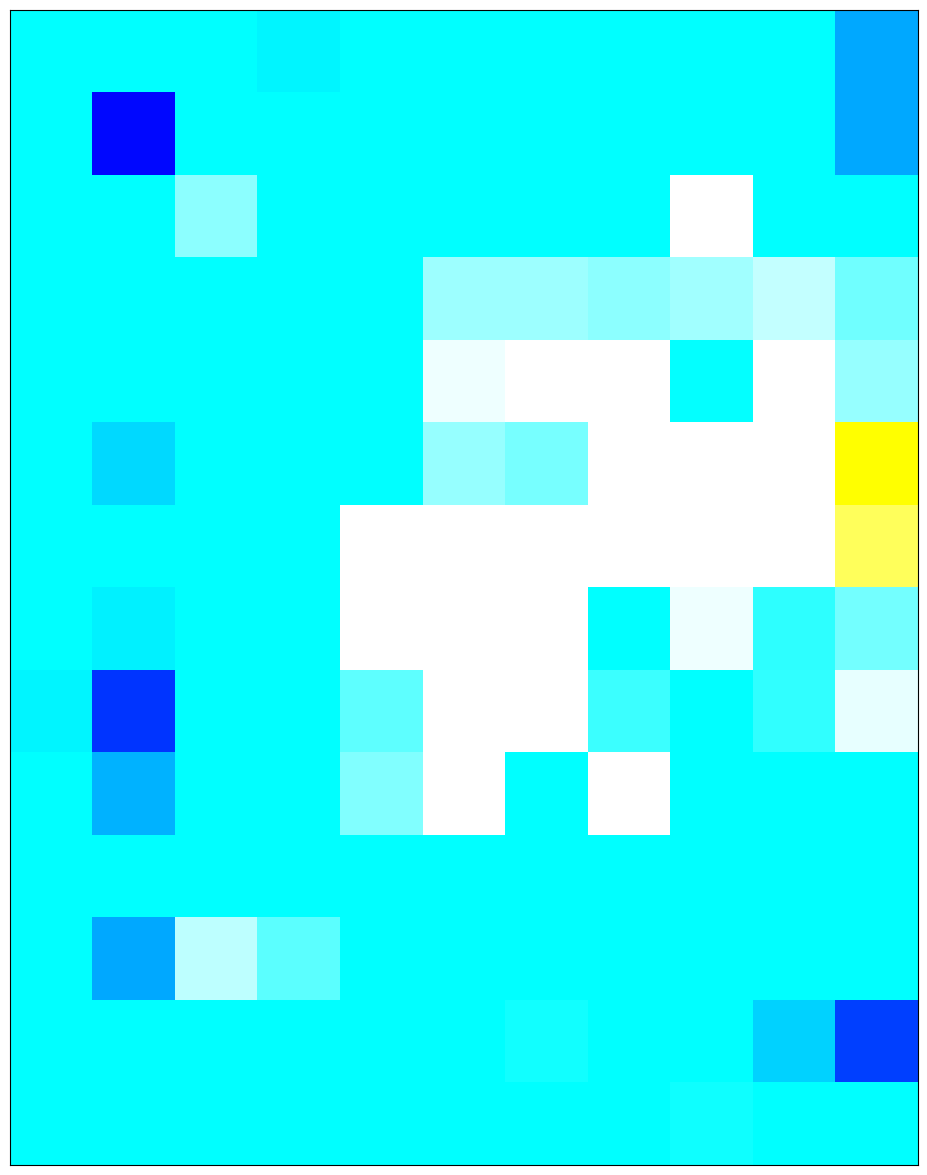

In [151]:
%matplotlib inline

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))